## The Corona Virus.

Summer 2019 we obtained mortality percentages of the corona virus for 10 age groups between 0 and 100.
They have mortalities of :
0.0 0.0 0.0 0.3 0.5 1.1 3.9 13.4 20.6 23.1

As I was 70 then and I didnt believe that the mortality suddenly jumps from 3.9% to 13.4% on the 70th birthday, I would like to know what my chances are when the virus attacks.

Demonstartion:
1. SplinesDynamicModel
2. NestedSampler
3. Constraints on the Likelihood


In [1]:
import numpy as numpy
import math

from astropy.io import ascii

from BayesicFitting import NestedSampler
from BayesicFitting import formatter as fmt
from BayesicFitting import plotFit
from BayesicFitting import Tools
import matplotlib.pyplot as plt

from BayesicFitting import SplinesDynamicModel

In [2]:
%matplotlib inline
#%matplotlib osx

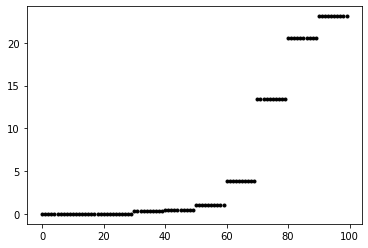

In [3]:
ky = numpy.arange( 100, dtype=int )
py = numpy.asarray( [0,0,0,0.3,0.5,1.1,3.9,13.4,20.6,23.1] )

perc = py[ ky // 10 ]
year = numpy.asarray( ky, dtype=float )

plt.plot( year, perc, 'k.' )
plt.show()

We need a model to fit to the data. As continuity is important we turn to a splines model.

At first we try a splinesmodel with a fixed number of knots. In this case 3 as there is not much curvature in the problem. 

In [4]:
# We need initial knot settings
knots =[0, 50, 100]

mdl = SplinesDynamicModel( knots=knots, dynamic=False, modifiable=True )
mdl.setLimits( lowLimits=[-20.0,-20.0], highLimits=[+100.0,100.0] )


Fit all parameters of
  ModBasicSplines of order 3 with 3 knots.
Using a Gauss error distribution with unknown scale
Moving the walkers with   GalileanEngine  ChordEngine  StructureEngine
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Iteration     logZ        H       LowL     npar
    4003      -202.     29.2      -170.      6 
Parameters   [   -1.226    5.025  -13.813   28.244   21.987    1.337]
Engines              success     reject     failed       best      calls
GalileanEngine         35851      11117       7389          0       4003
ChordEngine            28065      45983          0          0       4003
StructureEngine         1572          0       2431          0       4003
Calls to LogL         143525   to dLogL      11117
Samples        4103
Evidence       -87.924 +-      0.235


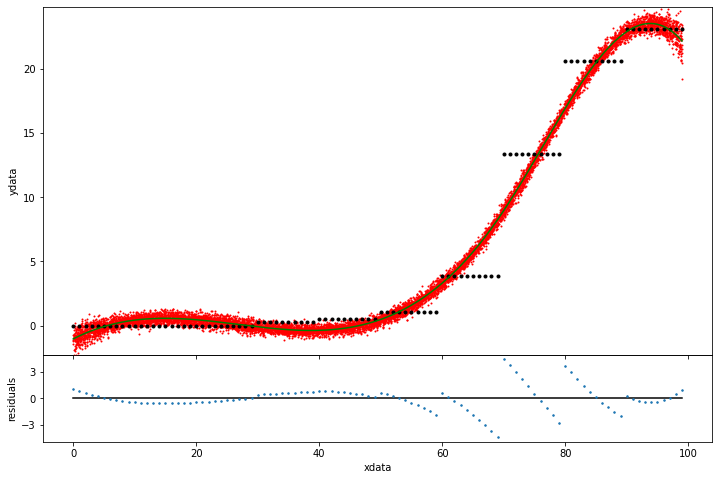

In [5]:
ns = NestedSampler( year, mdl, perc, seed=1234 )
ns.distribution.setLimits( [0.01,100] )
#ns.verbose = 2
evid = ns.sample( plot=True )



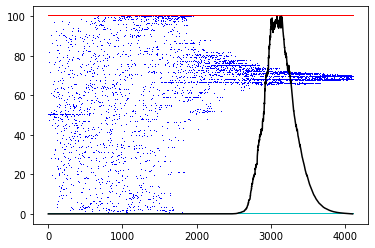

In [6]:
## plot the evolution of the knot locations and of the sample weights

sl = ns.samples
cc = ['k,', 'b,', 'r,', 'g,', 'c,', 'm,']
mxk = 5
ka = numpy.zeros( ( mxk, len( sl ) ), dtype=float )
plt.figure( "knots" )
for k,s in enumerate( sl ) :
    n = len( s.model.knots )
    ka[:n,k] = s.model.knots
for j in range( mxk ) :
    plt.plot( ka[j,:], cc[j%6] )
wgts = sl.getWeightEvolution()
maxw = max( wgts )
plt.plot( 100 * wgts / maxw, 'k-' )
plt.show()



In the model some points drop below zero. That of course is impossible for a mortality rate. By definition the mortality is larger or equal to zero. 

We could enforce positivity by having all parameter >= 0, so that all spline blobs which sum to the model result, are also positive. However that is too much, we need the sum to be positive, everywhere. The individual spline blobs we dont care about.

Lets enforce positivity in our model results for all ages 0 to 100, with a constrain method.

In [7]:
def constrainPos( logL, problem, allpars, lowLhood ):
    xx = numpy.arange( 101, dtype=float )
    yy = problem.model.result( xx, allpars[:-1] )
    if numpy.any( yy < 0 ):
        return lowLhood - 1       ## assign to the logLikelhood to avoid this area 
    else :
        return logL               ## return unchanged logLikelihood
    

Fit all parameters of
  ModBasicSplines of order 3 with 3 knots.
Using a Gauss error distribution with unknown scale
Moving the walkers with   GalileanEngine  ChordEngine  StructureEngine
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Iteration     logZ        H       LowL     npar
    3935      -207.     28.1      -175.      6 
Parameters   [    0.001    3.993  -11.652   27.853   21.899    1.386]
Engines              success     reject     failed       best      calls
GalileanEngine         35101       9781      10284          0       3935
ChordEngine            27384      67772          0          0       3935
StructureEngine         1504          0       2431          0       3935
Calls to LogL         164038   to dLogL       9781
Samples        4035
Evidence       -89.687 +-      0.230


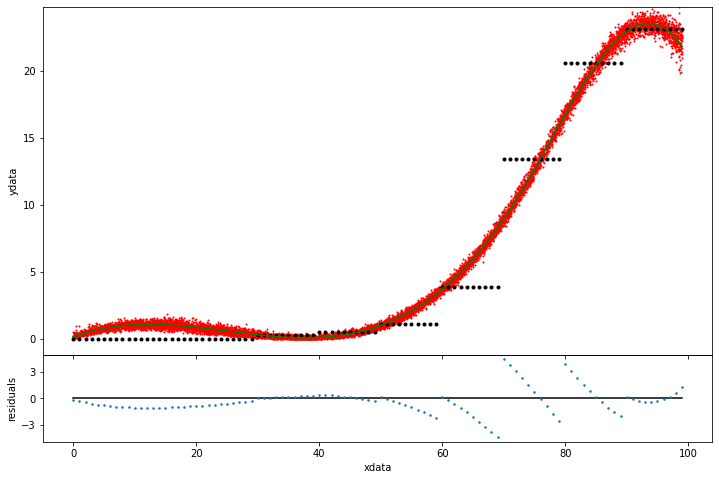

In [8]:
ns = NestedSampler( year, mdl, perc, seed=1234 )
ns.distribution.setLimits( [0.01,100.0] )
#ns.verbose = 2
ns.distribution.constrain = constrainPos
evid = ns.sample( plot=True )


Although we lost our negative mortality rates, the model is not very satisfying. A bump at 10 years for which there is no evidence in the data at all; too slow rise between 50 and 70; and a top at 95. Moreover the log evidence decreased from -87.9 to -89.7, almost 2 (log)points, which means that this model is almost 100 times less likely.

Lets see if the model can find the number of knots and their locations by itself. We define a dynamic, modifiable basic splines model.

In [9]:
# We need initial knot settings
knots =[0, 50, 100]

mdl = SplinesDynamicModel( knots=knots, maxKnots=5, minDistance=0.1 )
mdl.setLimits( lowLimits=[-10.0,-10.0], highLimits=[+100.0,100.0] )


Fit all parameters of
  DynModBasicSplines of order 3 with 3 knots.
Using a Gauss error distribution with unknown scale
Moving the walkers with   GalileanEngine  BirthEngine  DeathEngine  StructureEngine
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Iteration     logZ        H       LowL     npar
    4504      -192.     32.1      -154.      8 
Parameters   [    0.056    0.774   -1.543    3.533   20.300   23.219   23.427    1.113]
Engines              success     reject     failed       best      calls
GalileanEngine         40163      13235      22015          0       6103
BirthEngine              578       8989        825          0       6103
DeathEngine              521       3399       2183          0       6103
StructureEngine         7005          0       8567          0       6103
Calls to LogL         113007   to dLogL      13235
Samples        4604
Evidence       -83.209 +-      0.246


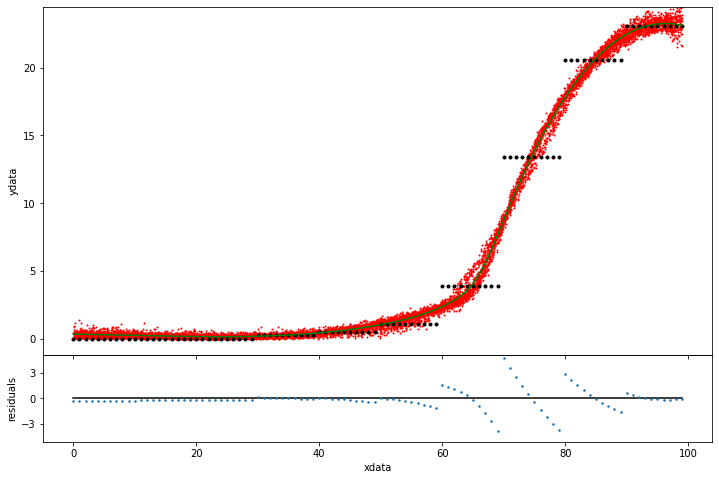

In [10]:
eng = ["galilean", "birth", "death", "struct"]
ns = NestedSampler( year, mdl, perc, engines=eng, seed=1234 )
ns.distribution.setLimits( [0.01,100] )
ns.distribution.constrain = constrainPos
#ns.verbose = 2
evid = ns.sample( plot=True )



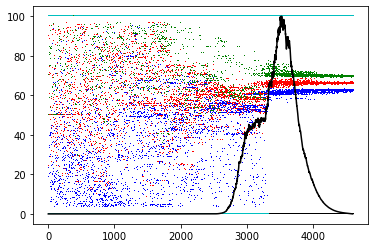

In [11]:
## plot the evolution of the knot locations and of the sample weights

sl = ns.samples
cc = ['k,', 'b,', 'r,', 'g,', 'c,', 'm,']
mxk = 5
ka = numpy.zeros( ( mxk, len( sl ) ), dtype=float )
for k,s in enumerate( sl ) :
    n = len( s.model.knots )
    ka[:n,k] = s.model.knots
for j in range( mxk ) :
    plt.plot( ka[j,:], cc[j%6] )
wgts = sl.getWeightEvolution()
maxw = max( wgts )
plt.plot( 100 * wgts / maxw, 'k-' )
plt.show()




This model looks a lot better. Also the evidence is better by 2 points, from -87.9 to -83.2.

Back to my original question: What is my mortality at the age of 70.

In [12]:
rate = sl.average( 70 )
stdv = sl.error
print( "mortality %6.2f +- %6.2f" % ( rate[0], stdv[0] ) )

mortality   8.23 +-   0.44
